In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.argv = ["calibrate.py"]

In [4]:
import sys
import os
path = os.path.abspath('.'+"/../../..")
sys.path.append(path)

import math
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import pathlib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
import torch.utils.data as tud
from tqdm import tqdm

from train.calibration.calibrate_metrics import *
from train.calibration.calibrate import inference_dataset
from train.args import whichgame_args
from data_util.dataset import DatasetGetter
from data_util.data_utils import populate_classes_lists
from train.net.network import Net

2021-11-10 13:59:06.683985: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-11-10 13:59:06.684009: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/liticia/whichgame_project/whichgame-ai-liticia


In [5]:
def get_scores(input, n_bins=10, device='cuda'):

    logits = input[1]['logits'].to(device)
    labels = input[1]['labels'].to(device)
    num_classes = input[1]['num_classes']

    nll = nn.CrossEntropyLoss().to(device)
    ece = ECELoss(n_bins).to(device)
    ada_ece = AdaptiveECELoss(n_bins).to(device)
    classwise_ece = ClasswiseECELoss(num_classes, n_bins).to(device)

    nll_score = nll(logits, labels).item()
    ece_score = ece(logits, labels).item()
    ada_ece_score = ada_ece(logits, labels).item()
    classwise_ece_score = classwise_ece(logits, labels).item()
    accuracy_score = logits.argmax(1).eq(labels).float().mean().item()
    print(input[0],': \n')
    print('- NLL: %.3f,\n- ECE: %.3f,\n- Ada-ECE: %.3f,\n- Classwise-ECE: %.3f,\n- Accuracy: %.3f' % \
        (nll_score, ece_score, ada_ece_score, classwise_ece_score, accuracy_score))


def run_model(model_path, test_dataset, args=None, message='', plot=False, num_bins=10):
   
    
    # Load the model
    
    print(f"Will load checkpoint from {model_path}")

    if args.model_name=='net':
        model = Net(
            backbone_name=args.backbone_name,
            num_classes=args.num_ingame_classes,
            num_outgame_subclasses=args.num_outgame_classes,
        )
    ext = pathlib.Path(model_path).suffix
    if ext == '.ckpt':
        model.load_state_dict(
            torch.load(model_path, map_location="cpu")["state_dict"]
        )
    if ext == '.pth':
        model.load_state_dict(
            torch.load(model_path)
            )
    model = model.eval().to(args.device)
    print(f"Model state succesfully loaded from {model_path}")

    outputs = get_model_outputs(test_dataset, model, args)
    
    print(message)

    for input in outputs.items():
        get_scores(input, device=args.device)
        if plot:
            confidences, predictions = torch.max(input[1]['logits'], 1)
            reliability_plot(confidences.cpu(), predictions.cpu(), input[1]['labels'].cpu(), num_bins)
            
            
def get_model_outputs(test_dataset, model, args):

    (   xs,
        ys_ingame_t,
        ys_whichgame_t,
        ys_subclass_if_outgame_t,
        ps_ingame_t,
        ps_whichgame_t,
        ps_subclass_if_outgame_t,
        fts_t,
    ) = inference_dataset(test_dataset, model, args, ret_just_one_x=True)
    res_per_class = {'Ingame':{'logits': ps_ingame_t, 
                               'labels': ys_ingame_t, 
                               'num_classes': 2}, 
                    'Outgame':{'logits': ps_subclass_if_outgame_t, 
                               'labels': ys_subclass_if_outgame_t, 
                               'num_classes': args.num_outgame_classes}, 
                    'Whichgame':{'logits': ps_whichgame_t, 
                                 'labels': ys_whichgame_t, 
                                 'num_classes': args.num_ingame_classes}}
    return res_per_class

from glob import glob    
def test_model(args, plot=False, num_bins=10):
    # Load args and classes
    args.device = "cuda" if args.n_gpus > 0 else "cpu"
    args.ckpts_out_dir = os.path.join(
        args.ckpt_dir, args.project_name, args.experiment_name
    )
    (
        ingame_classes,
        outgame_classes,
        ingame_class_to_idx,
        outgame_class_to_idx,
    ) = populate_classes_lists(
        args.data_dir, args.ingame_subdir, args.outgame_cats_subdir
    )

    args.num_ingame_classes = len(ingame_classes)
    args.num_outgame_classes = len(outgame_classes)

    # Dataset
    dataset_getter = DatasetGetter(
        args.data_dir,
        ingame_class_to_idx,
        args.labels_dir,
        args.ingame_subdir,
        args.outgame_subdir,
        args.outgame_cats_subdir,
        valid_test_twids_paths=(args.valid_twids_path, args.test_twids_path),
        outgame_class_to_idx=outgame_class_to_idx,)

    test_dataset = dataset_getter.get_labeled_ingame_dataset("test")
    

    ckpt_path = os.path.join(args.ckpts_out_dir, args.ckpt_file) 
    run_model(ckpt_path, test_dataset, args=args, message='Before calibration',plot=plot, num_bins=num_bins)

    ckpt_path = os.path.join(path,"train/calibration/calibrate_outs",args.calibrator_name,args.ckpt_file_ac)
    run_model(ckpt_path, test_dataset, args=args, message='After calibration', plot=plot, num_bins=num_bins)

    
    

  0%|                                                                                                                       | 0/67 [00:00<?, ?it/s]

Will load checkpoint from /bigdata0/checkpoints/whichgame-tests/mobilenet-outofline/epoch-epoch=00049.ckpt
Model state succesfully loaded from /bigdata0/checkpoints/whichgame-tests/mobilenet-outofline/epoch-epoch=00049.ckpt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.58it/s]


Before calibration
Ingame : 

- NLL: 0.352,
- ECE: 0.233,
- Ada-ECE: 0.233,
- Classwise-ECE: 0.239,
- Accuracy: 0.961


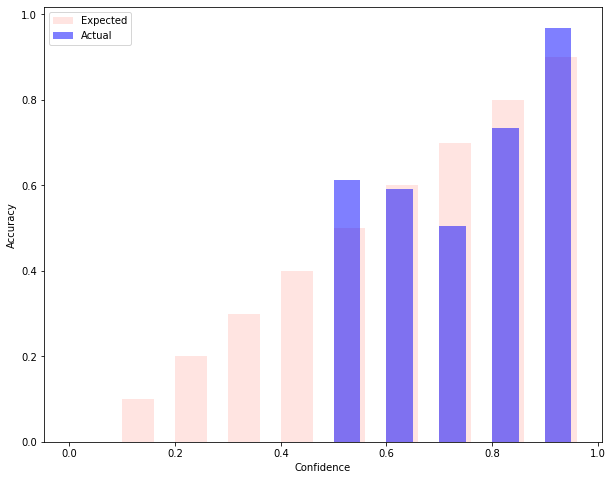

Outgame : 

- NLL: 0.314,
- ECE: 0.269,
- Ada-ECE: 0.269,
- Classwise-ECE: 0.269,
- Accuracy: 1.000


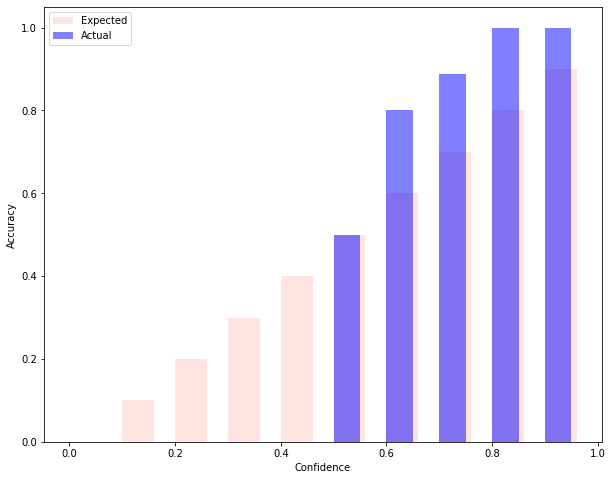

Whichgame : 

- NLL: 3.456,
- ECE: 0.914,
- Ada-ECE: 0.914,
- Classwise-ECE: 0.009,
- Accuracy: 0.947


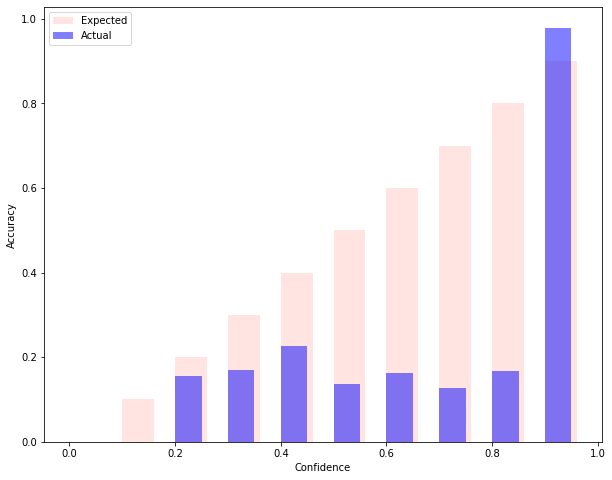

  0%|                                                                                                                       | 0/67 [00:00<?, ?it/s]

Will load checkpoint from /home/liticia/whichgame_project/whichgame-ai-liticia/train/calibration/calibrate_outs/calibrateFC/mobilenet-outofline_cf1cb73_calibrated.pth
Model state succesfully loaded from /home/liticia/whichgame_project/whichgame-ai-liticia/train/calibration/calibrate_outs/calibrateFC/mobilenet-outofline_cf1cb73_calibrated.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.57it/s]


After calibration
Ingame : 

- NLL: 0.350,
- ECE: 0.236,
- Ada-ECE: 0.235,
- Classwise-ECE: 0.238,
- Accuracy: 0.962


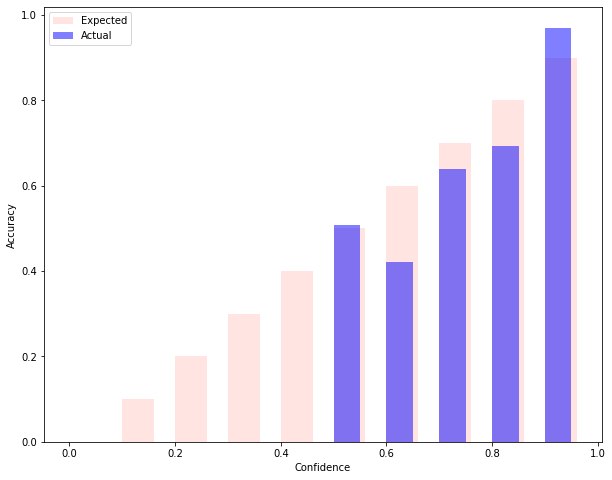

Outgame : 

- NLL: 0.314,
- ECE: 0.269,
- Ada-ECE: 0.269,
- Classwise-ECE: 0.269,
- Accuracy: 1.000


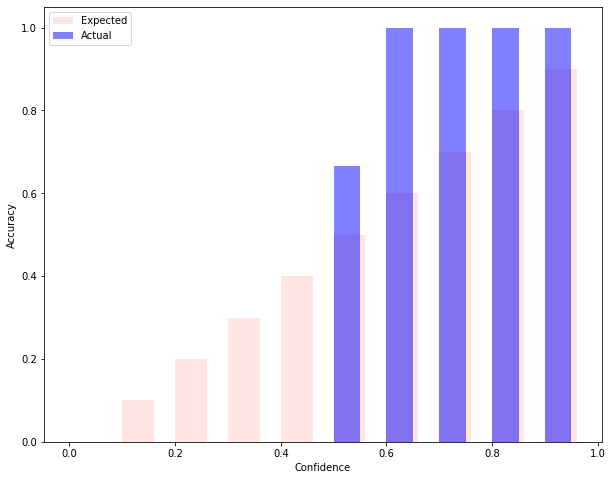

Whichgame : 

- NLL: 3.452,
- ECE: 0.920,
- Ada-ECE: 0.920,
- Classwise-ECE: 0.009,
- Accuracy: 0.953


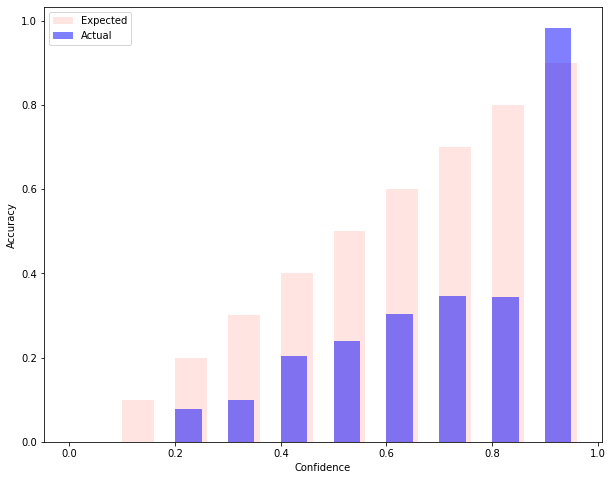

In [35]:
args = whichgame_args().parse_args()
args.calibrator_name = "calibrateFC"
test_model(args, plot=True, num_bins=10)

  0%|                                                                         | 0/67 [00:00<?, ?it/s]

Will load checkpoint from /bigdata0/checkpoints/whichgame-tests/mobilenet-outofline/epoch-epoch=00049.ckpt
Model state succesfully loaded from /bigdata0/checkpoints/whichgame-tests/mobilenet-outofline/epoch-epoch=00049.ckpt


100%|████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  6.75it/s]


Before calibration
Ingame : 

- NLL: 0.352,
- ECE: 0.233,
- Ada-ECE: 0.233,
- Classwise-ECE: 0.239,
- Accuracy: 0.961


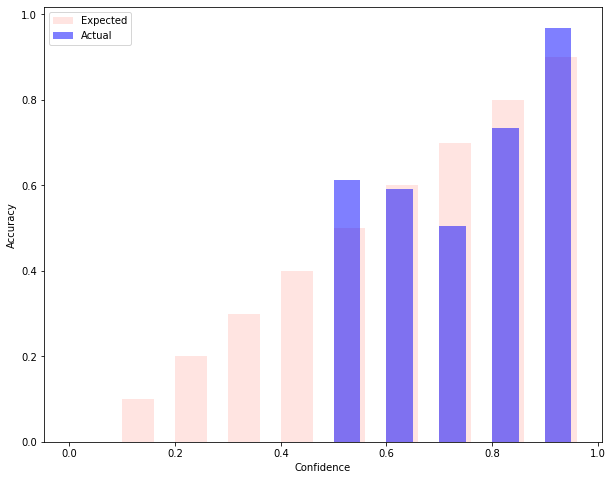

Outgame : 

- NLL: 0.314,
- ECE: 0.269,
- Ada-ECE: 0.269,
- Classwise-ECE: 0.269,
- Accuracy: 1.000


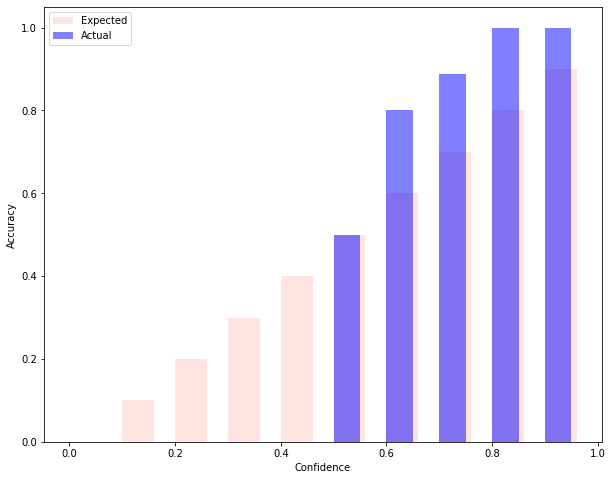

Whichgame : 

- NLL: 3.456,
- ECE: 0.914,
- Ada-ECE: 0.914,
- Classwise-ECE: 0.009,
- Accuracy: 0.947


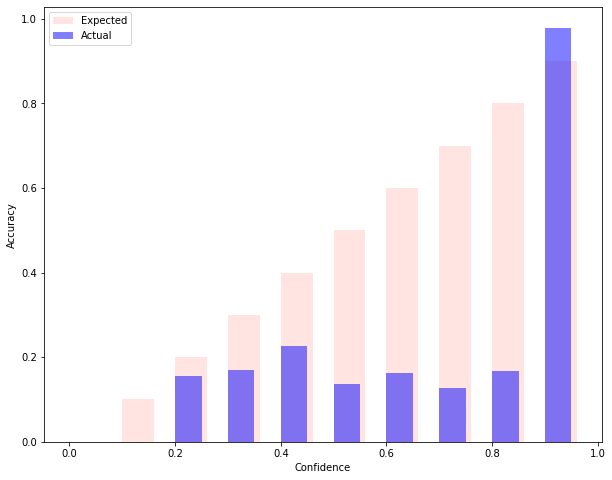

  0%|                                                                         | 0/67 [00:00<?, ?it/s]

Will load checkpoint from /home/liticia/whichgame_project/whichgame-ai-liticia/train/calibration/calibrate_outs/calibrateWithFocallLoss/mobilenet-outofline_cf1cb73_calibrated.pth
Model state succesfully loaded from /home/liticia/whichgame_project/whichgame-ai-liticia/train/calibration/calibrate_outs/calibrateWithFocallLoss/mobilenet-outofline_cf1cb73_calibrated.pth


100%|████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  6.79it/s]


After calibration
Ingame : 

- NLL: 0.350,
- ECE: 0.236,
- Ada-ECE: 0.235,
- Classwise-ECE: 0.239,
- Accuracy: 0.962


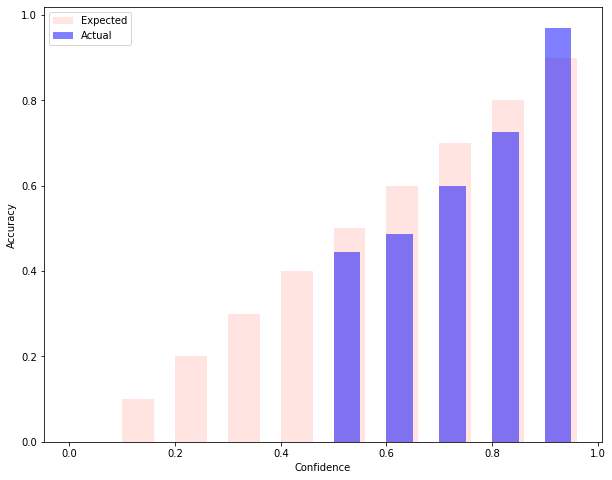

Outgame : 

- NLL: 0.314,
- ECE: 0.269,
- Ada-ECE: 0.269,
- Classwise-ECE: 0.269,
- Accuracy: 1.000


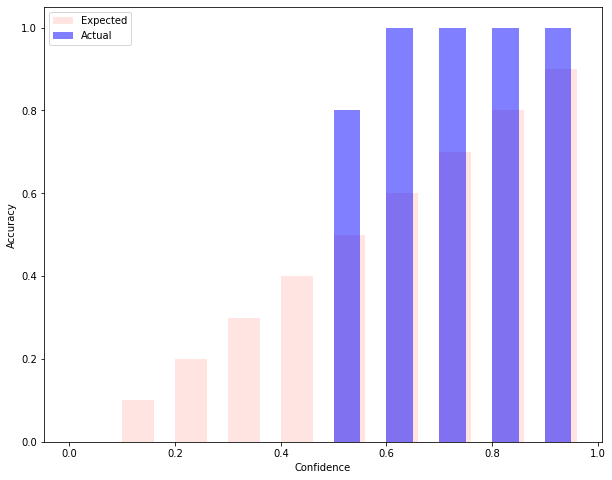

Whichgame : 

- NLL: 3.453,
- ECE: 0.918,
- Ada-ECE: 0.918,
- Classwise-ECE: 0.009,
- Accuracy: 0.951


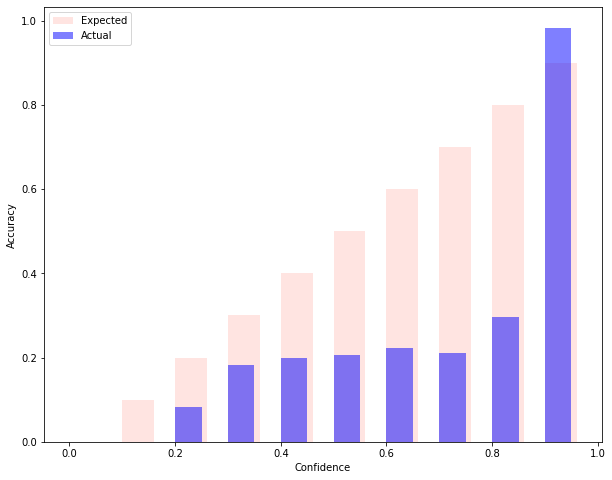

In [10]:
# FocallLoss
args = whichgame_args().parse_args()
args.calibrator_name = "calibrateWithFocallLoss"
args.gamma = 2
test_model(args, plot=True, num_bins=10)

Will load checkpoint from /bigdata0/checkpoints/whichgame-tests/mobilenet-outofline/epoch-epoch=00049.ckpt


  0%|                                                                                                                       | 0/67 [00:00<?, ?it/s]

Model state succesfully loaded from /bigdata0/checkpoints/whichgame-tests/mobilenet-outofline/epoch-epoch=00049.ckpt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.07it/s]


Before calibration
Ingame : 

- NLL: 0.352,
- ECE: 0.233,
- Ada-ECE: 0.233,
- Classwise-ECE: 0.239,
- Accuracy: 0.961


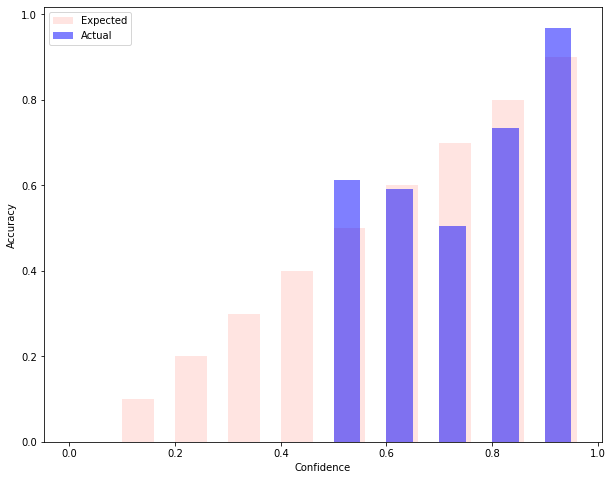

Outgame : 

- NLL: 0.314,
- ECE: 0.269,
- Ada-ECE: 0.269,
- Classwise-ECE: 0.269,
- Accuracy: 1.000


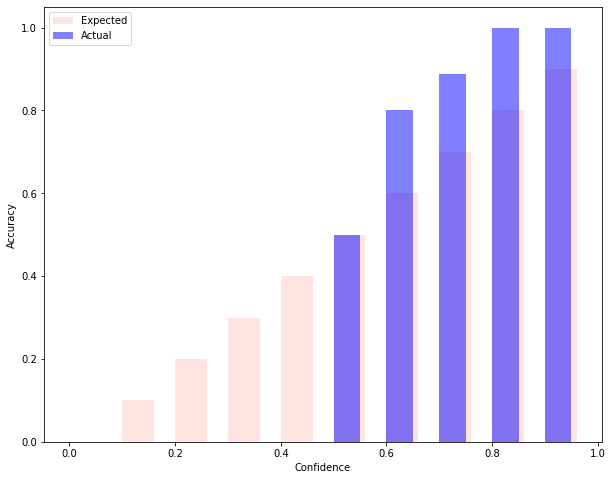

Whichgame : 

- NLL: 3.456,
- ECE: 0.914,
- Ada-ECE: 0.914,
- Classwise-ECE: 0.009,
- Accuracy: 0.947


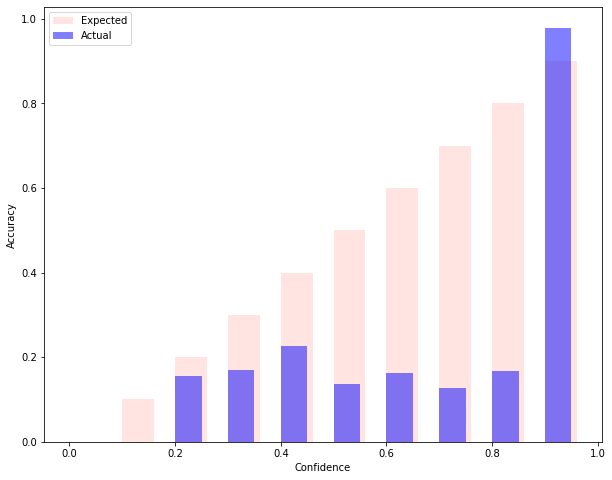

  0%|                                                                                                                       | 0/67 [00:00<?, ?it/s]

Will load checkpoint from /home/liticia/whichgame_project/whichgame-ai-liticia/train/calibration/calibrate_outs/calibrateWithTemperature/mobilenet-outofline_cf1cb73_calibrated.pth
Model state succesfully loaded from /home/liticia/whichgame_project/whichgame-ai-liticia/train/calibration/calibrate_outs/calibrateWithTemperature/mobilenet-outofline_cf1cb73_calibrated.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:09<00:00,  6.73it/s]


After calibration
Ingame : 

- NLL: 0.352,
- ECE: 0.233,
- Ada-ECE: 0.233,
- Classwise-ECE: 0.239,
- Accuracy: 0.961


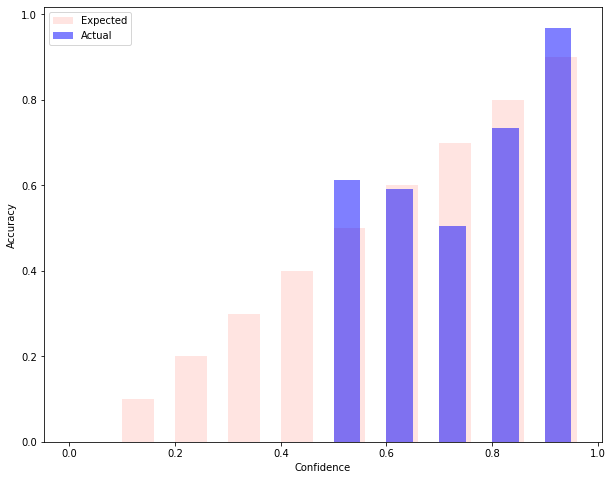

Outgame : 

- NLL: 0.314,
- ECE: 0.269,
- Ada-ECE: 0.269,
- Classwise-ECE: 0.269,
- Accuracy: 1.000


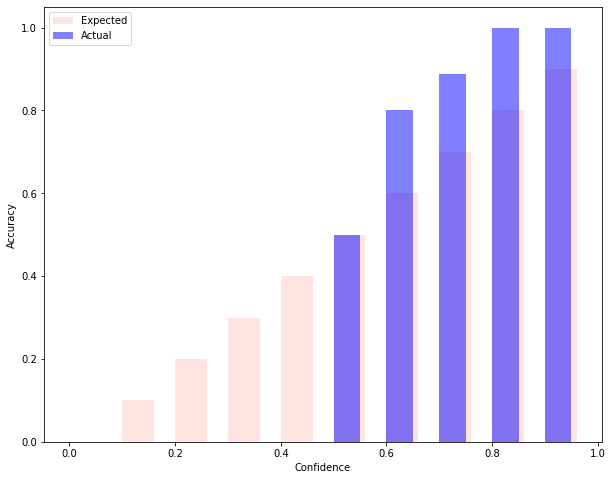

Whichgame : 

- NLL: 3.456,
- ECE: 0.914,
- Ada-ECE: 0.914,
- Classwise-ECE: 0.009,
- Accuracy: 0.947


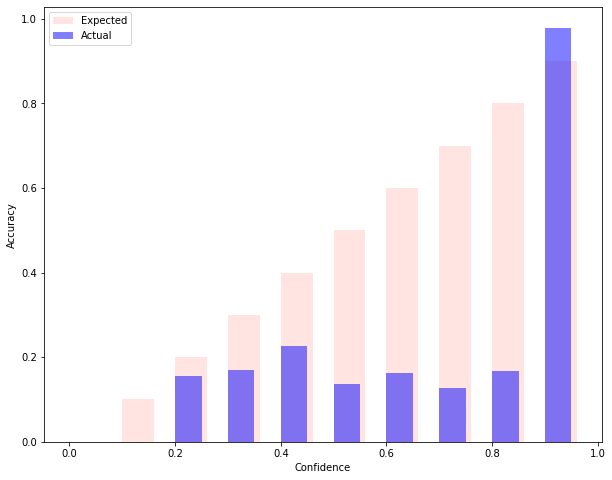

In [6]:
# Temperature scale
args = whichgame_args().parse_args()
args.calibrator_name = "calibrateWithTemperature"
test_model(args, plot=True, num_bins=10)